# Static Analysis

## Handcrafted

only for binary analysis, not symbolic analysis.

In [ ]:
# Get a 32-bit pe file #w是web的意思，加!是linux是虛擬機會幫我們下載
!wget https://the.earth.li/~sgtatham/putty/latest/w32/putty.exe -O putty32.exe

--2020-04-06 05:56:36--  https://the.earth.li/~sgtatham/putty/latest/w32/putty.exe
Resolving the.earth.li (the.earth.li)... 93.93.131.124, 2a00:1098:86:4d:c0ff:ee:15:900d
Connecting to the.earth.li (the.earth.li)|93.93.131.124|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://the.earth.li/~sgtatham/putty/0.73/w32/putty.exe [following]
--2020-04-06 05:56:38--  https://the.earth.li/~sgtatham/putty/0.73/w32/putty.exe
Reusing existing connection to the.earth.li:443.
HTTP request sent, awaiting response... 200 OK
Length: 1096080 (1.0M) [application/x-msdos-program]
Saving to: ‘putty32.exe’

putty32.exe         100%[===================>]   1.04M   724KB/s    in 1.5s    

2020-04-06 05:56:40 (724 KB/s) - ‘putty32.exe’ saved [1096080/1096080]



In [ ]:
# Get a 64-bit pe file
!wget https://the.earth.li/~sgtatham/putty/latest/w64/putty.exe -O putty64.exe

--2020-04-02 15:32:56--  https://the.earth.li/~sgtatham/putty/latest/w64/putty.exe
Resolving the.earth.li (the.earth.li)... 93.93.131.124, 2a00:1098:86:4d:c0ff:ee:15:900d
Connecting to the.earth.li (the.earth.li)|93.93.131.124|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://the.earth.li/~sgtatham/putty/0.73/w64/putty.exe [following]
--2020-04-02 15:32:57--  https://the.earth.li/~sgtatham/putty/0.73/w64/putty.exe
Reusing existing connection to the.earth.li:443.
HTTP request sent, awaiting response... 200 OK
Length: 1179024 (1.1M) [application/x-msdos-program]
Saving to: ‘putty64.exe’

putty64.exe         100%[===================>]   1.12M  2.08MB/s    in 0.5s    

2020-04-02 15:32:57 (2.08 MB/s) - ‘putty64.exe’ saved [1179024/1179024]



In [ ]:
!ls -al

total 1088
drwxr-xr-x 1 root root    4096 Apr  3 02:22 .
drwxr-xr-x 1 root root    4096 Apr  3 02:20 ..
drwxr-xr-x 1 root root    4096 Mar 31 16:39 .config
-rw-r--r-- 1 root root 1096080 Sep 22  2019 putty32.exe
drwxr-xr-x 1 root root    4096 Mar 18 16:23 sample_data


### EXE file?


看副檔名是不是exe結尾，但是很多惡意程式會先改副檔名等到要攻擊時才改成exe，所以這個方法不好

In [ ]:
def isExe(fp):
    if fp.endswith("exe"):
        return True
    else:
        return False

In [ ]:
isExe("/content/putty32.exe")

True

### MZ (DOS) file?

In [ ]:
def isMZ(fp):
    with open(fp, 'rb') as hnd:
        if hnd.read(2) == b"MZ":
            return True
        else:
            return False

In [ ]:
isMZ("/content/putty32.exe")

True

### PE file?
先讀前兩個byte是不是MZ，接著從第0個byte跳120個offset，然後再往後讀4個byte看是不是"PE\0\0"，如果是的話就是PE file

In [ ]:
def isPE(fp):
  try:
    with open(fp, 'rb') as hnd:
      if hnd.read(2) != b"MZ":
        return False
      hnd.seek(0x3c, 0)#從第０byte跳 0x3c(120) 這麼多byte

      import struct
      offset = struct.unpack('<i', hnd.read(4))[0] #往後讀4位，read取出來是list所以要用[0]
      hnd.seek(offset, 0)
      if hnd.read(4) == b"PE\0\0": #往後讀4byte
        return True
      else:
        print("isMZ, not PE.")
        return False
  except:
    return False

In [ ]:
isPE("/content/putty32.exe")

True

### Architecture? (Machine)

In [ ]:
def machine(fp):
  try:
    with open(fp, 'rb') as hnd:
      hnd.seek(0x3c, 0)

      import struct
      offset = struct.unpack('<i', hnd.read(4))[0]
      hnd.seek(offset, 0)
      hnd.read(4)
      machine = struct.unpack("<H", hnd.read(2))[0]

      if machine == 332: # IMAGE_FILE_MACHINE_I386  #332是十進位
        return "IA-32 (32-bit x86)"
      elif machine == 512: #IMAGE_FILE_MACHINE_IA64:
        return "IA-64 (Itanium)"
      elif machine == 34404: #IMAGE_FILE_MACHINE_AMD64:
        return "AMD64 (64-bit x86)"
      else:
        return "Unknown architecture"
  except:
    return "Exception"

In [ ]:
machine("/content/putty32.exe")

'IA-32 (32-bit x86)'

In [ ]:
machine("/content/putty64.exe")

'AMD64 (64-bit x86)'

### Hex representation

In [ ]:
import binascii

def printHex(fp, limit = 64):
  with open(fp, 'rb') as f:
    content = f.read()

    i = 0
    for b in content:
      print(format(b, "02x"), " ", end="") # 2是一次印兩位x是16進位，0是如果不夠兩位就補零
      if i% 8 == 7:
        print("")
      i += 1
      if i == limit:
        break

In [ ]:
printHex("/content/putty32.exe", limit = 160)

4d  5a  78  00  01  00  00  00  
04  00  00  00  00  00  00  00  
00  00  00  00  00  00  00  00  
40  00  00  00  00  00  00  00  
00  00  00  00  00  00  00  00  
00  00  00  00  00  00  00  00  
00  00  00  00  00  00  00  00  
00  00  00  00  78  00  00  00  
0e  1f  ba  0e  00  b4  09  cd  
21  b8  01  4c  cd  21  54  68  
69  73  20  70  72  6f  67  72  
61  6d  20  63  61  6e  6e  6f  
74  20  62  65  20  72  75  6e  
20  69  6e  20  44  4f  53  20  
6d  6f  64  65  2e  24  00  00  
50  45  00  00  4c  01  07  00  
be  3e  87  5d  00  00  00  00  
00  00  00  00  e0  00  02  01  
0b  01  0e  00  00  d8  08  00  
00  a0  07  00  00  00  00  00  


### Hash

In [ ]:
import hashlib

#### MD5 and SHA265

You can check it against with the announced hash values in https://www.chiark.greenend.org.uk/~sgtatham/putty/latest.html

In [ ]:
filenamepath = "/content/putty32.exe"
md5_value = hashlib.md5(open(filenamepath, 'rb').read()).hexdigest() #hexdigest()要用這個代表16進位
print(md5_value)

9052d06c6ac53471f8496263f8fef2eb


In [ ]:
sha256_value = hashlib.sha256(open(filenamepath, 'rb').read()).hexdigest()
print(sha256_value)

736330aaa3a4683d3cc866153510763351a60062a236d22b12f4fe0f10853582


#### GPG

Check the calculated (GNU Privacy Guard) GPG value against with the value in [PuTTY web page](https://www.chiark.greenend.org.uk/~sgtatham/putty/latest.html). Google "digital signature" first.

* Signature ([here](https://www.chiark.greenend.org.uk/~sgtatham/putty/latest.html))
* Public Key ([here](https://www.chiark.greenend.org.uk/~sgtatham/putty/keys.html))



In [ ]:
!wget https://the.earth.li/~sgtatham/putty/latest/w32/putty.exe.gpg

--2020-04-03 02:24:18--  https://the.earth.li/~sgtatham/putty/latest/w32/putty.exe.gpg
Resolving the.earth.li (the.earth.li)... 93.93.131.124, 2a00:1098:86:4d:c0ff:ee:15:900d
Connecting to the.earth.li (the.earth.li)|93.93.131.124|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://the.earth.li/~sgtatham/putty/0.73/w32/putty.exe.gpg [following]
--2020-04-03 02:24:19--  https://the.earth.li/~sgtatham/putty/0.73/w32/putty.exe.gpg
Reusing existing connection to the.earth.li:443.
HTTP request sent, awaiting response... 200 OK
Length: 438 [application/pgp-signature]
Saving to: ‘putty.exe.gpg’

putty.exe.gpg       100%[===================>]     438  --.-KB/s    in 0s      

2020-04-03 02:24:19 (122 MB/s) - ‘putty.exe.gpg’ saved [438/438]



In [ ]:
!wget https://www.chiark.greenend.org.uk/~sgtatham/putty/keys/release-2018.asc

--2020-04-03 02:24:41--  https://www.chiark.greenend.org.uk/~sgtatham/putty/keys/release-2018.asc
Resolving www.chiark.greenend.org.uk (www.chiark.greenend.org.uk)... 212.13.197.231, 2001:ba8:1e3::
Connecting to www.chiark.greenend.org.uk (www.chiark.greenend.org.uk)|212.13.197.231|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2090 (2.0K) [text/plain]
Saving to: ‘release-2018.asc’

release-2018.asc    100%[===================>]   2.04K  --.-KB/s    in 0s      

2020-04-03 02:24:42 (115 MB/s) - ‘release-2018.asc’ saved [2090/2090]



In [ ]:
!gpg --import release-2018.asc #gpg是簽章，imprort 公鑰

gpg: key 6289A25F4AE8DA82: 1 signature not checked due to a missing key
gpg: /root/.gnupg/trustdb.gpg: trustdb created
gpg: key 6289A25F4AE8DA82: public key "PuTTY Releases <putty@projects.tartarus.org>" imported
gpg: Total number processed: 1
gpg:               imported: 1
gpg: no ultimately trusted keys found


In [ ]:
!gpg --verify putty.exe.gpg putty32.exe #使用公鑰驗證putty.exe

gpg: Signature made Sun 29 Sep 2019 02:30:33 PM UTC
gpg:                using RSA key E27394ACA3F9D9049522E0546289A25F4AE8DA82
gpg: Good signature from "PuTTY Releases <putty@projects.tartarus.org>" [unknown]
gpg: WARNING: This key is not certified with a trusted signature!
gpg:          There is no indication that the signature belongs to the owner.
Primary key fingerprint: E273 94AC A3F9 D904 9522  E054 6289 A25F 4AE8 DA82


# Virustotal

https://www.virustotal.com/gui/home/upload

# pefile


In [ ]:
!pip install pefile

     |████████████████████████████████| 71kB 2.2MB/s 
  Created wheel for pefile: filename=pefile-2019.4.18-cp36-none-any.whl size=60824 sha256=66ef4b403cabefcef123e9f40e35a33c273396edf01ecae13619f8386e00ea23
  Stored in directory: /root/.cache/pip/wheels/1c/a1/95/4f33011a0c013c872fe6f0f364dc463a2588120820e40a30d8
Successfully built pefile


In [ ]:
import pefile

### File Type

In [ ]:
filenamepath = "/content/putty32.exe"

pef = pefile.PE(filenamepath, fast_load = False)

In [ ]:
print(pef.is_dll())
print(pef.is_driver())
print(pef.is_exe())

False
False
True


### Machine, Timestamp, imphash

In [ ]:
print(pef.FILE_HEADER.Machine)

332


In [ ]:
import time
timestamp = pef.FILE_HEADER.TimeDateStamp  #不用自己去解析timestamp 用pef.裡面的function
print(time.strftime("%Y-%m-%d %H:%M:%S", time.localtime(timestamp)))

2019-09-22 09:28:30


In [ ]:
print(pef.get_imphash())

d803cf4cabab38ad6ac8123e3c7a53dd


### Section and Entropy

In [ ]:
def printSecEntropy(filenamepath):
  try:
    pef = pefile.PE(filenamepath, fast_load = False)

    total_size = 0
    accumulated_entropy = 0.0

    for sec in pef.sections: #把桃紅色裡面的東西印出來
      e = sec.get_entropy()
      m = sec.get_hash_md5()

      print(sec.Name, hex(sec.VirtualAddress), hex(sec.Misc_VirtualSize), sec.SizeOfRawData, e, m)

      accumulated_entropy += sec.SizeOfRawData*e
      total_size += sec.SizeOfRawData
    print('entropy', accumulated_entropy/total_size if total_size !=0 else 'None')
  except:
    print("Error")

# New Section

# New Section

In [ ]:
printSecEntropy("/content/putty32.exe") # .data .text是一個名字

b'.text\x00\x00\x00' 0x1000 0x8d65e 579584 6.631572922135495 c2a8f0f2df948e32017da4e4741c0758
b'.rdata\x00\x00' 0x8f000 0x26cac 159232 5.799113574975851 65b60216c5ccca9452dd0d1fd0a343d0
b'.data\x00\x00\x00' 0xb6000 0x4e30 2560 2.138903430830677 b4b7ec6b6bf4dfe41972c4b09d569565
b'.00cfg\x00\x00' 0xbb000 0x4 512 0.06116285224115448 3df28295fcf4f22f0619dbb667c6103e
b'.gfids\x00\x00' 0xbc000 0xb4 512 1.9161857250825571 c32633f1600732d51cd8162f12316160
b'.rsrc\x00\x00\x00' 0xbd000 0x4b030 307712 7.827657025649427 d2ae732e2833befe28cdebfac0e23e2e
b'.reloc\x00\x00' 0x109000 0x711c 29184 6.722490367754844 3f538e9cee3f455a7e53b8e3a5256d0d
entropy 6.836214686330019


### Packing

Malware sometimes packs itself with packing tool, because it can change its appearance for not being detected by antivirus engine.

A famous packer is UPX (https://en.wikipedia.org/wiki/UPX). Take a look at its [manual file](https://linux.die.net/man/1/upx).

However, these packing tools have "signature" as well. See https://github.com/cuckoosandbox/cuckoo/blob/master/cuckoo/private/peutils/UserDB.TXT

In [ ]:
!apt-get install upx

ERROR! Session/line number was not unique in database. History logging moved to new session 61
Reading package lists... Done
Building dependency tree       
Reading state information... Done
Note, selecting 'upx-ucl' instead of 'upx'
The following additional packages will be installed:
  libucl1
The following NEW packages will be installed:
  libucl1 upx-ucl
0 upgraded, 2 newly installed, 0 to remove and 25 not upgraded.
Need to get 401 kB of archives.
After this operation, 2,083 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu bionic/universe amd64 libucl1 amd64 1.03+repack-4 [23.9 kB]
Get:2 http://archive.ubuntu.com/ubuntu bionic/universe amd64 upx-ucl amd64 3.94-4 [377 kB]
Fetched 401 kB in 1s (544 kB/s)
Selecting previously unselected package libucl1:amd64.
(Reading database ... 133872 files and directories currently installed.)
Preparing to unpack .../libucl1_1.03+repack-4_amd64.deb ...
Unpacking libucl1:amd64 (1.03+repack-4) ...
Selecting previousl

In [ ]:
!cp putty32.exe putty32_packed.exe

In [ ]:
!upx putty32_packed.exe

                       Ultimate Packer for eXecutables
                          Copyright (C) 1996 - 2017
UPX 3.94        Markus Oberhumer, Laszlo Molnar & John Reiser   May 12th 2017

        File size         Ratio      Format      Name
   --------------------   ------   -----------   -----------
   1096080 ->    710544   64.83%    win32/pe     putty32_packed.exe

Packed 1 file.


In [ ]:
!ls -al

total 2768
drwxr-xr-x 1 root root    4096 Apr  3 03:33 .
drwxr-xr-x 1 root root    4096 Apr  3 02:20 ..
drwxr-xr-x 1 root root    4096 Mar 31 16:39 .config
-rw-r--r-- 1 root root 1096080 Sep 22  2019 putty32.exe
-rw-r--r-- 1 root root  710544 Apr  3 03:33 putty32_packed.exe
-rw-r--r-- 1 root root     438 Sep 29  2019 putty.exe.gpg
-rw-r--r-- 1 root root    2090 Aug 26  2018 release-2018.asc
drwxr-xr-x 1 root root    4096 Mar 18 16:23 sample_data
-rw-r--r-- 1 root root  499637 Apr  3 03:23 UserDB_.TXT
-rw-r--r-- 1 root root  499709 Apr  3 03:07 UserDB.TXT


In [ ]:
print(isPE("/content/putty32_packed.exe"))
print(machine("/content/putty32_packed.exe"))
print(hashlib.md5(open("/content/putty32_packed.exe", 'rb').read()).hexdigest())

True
IA-32 (32-bit x86)
f33426e2d4a1151033eaf0e36afd3443


In [ ]:
!gpg --verify putty.exe.gpg putty32_packed.exe

gpg: Signature made Sun 29 Sep 2019 02:30:33 PM UTC
gpg:                using RSA key E27394ACA3F9D9049522E0546289A25F4AE8DA82
gpg: BAD signature from "PuTTY Releases <putty@projects.tartarus.org>" [unknown]


BAD signature 因為他已經解pack過了，但如果把它執行起來又會是一樣的

In [ ]:
# pip install pefile
import peutils

In [ ]:
!wget https://raw.githubusercontent.com/cuckoosandbox/cuckoo/master/cuckoo/private/peutils/UserDB.TXT

--2020-04-03 03:07:54--  https://raw.githubusercontent.com/cuckoosandbox/cuckoo/master/cuckoo/private/peutils/UserDB.TXT
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 499709 (488K) [text/plain]
Saving to: ‘UserDB.TXT’

UserDB.TXT          100%[===================>] 488.00K  --.-KB/s    in 0.06s   

2020-04-03 03:07:54 (7.59 MB/s) - ‘UserDB.TXT’ saved [499709/499709]



In [ ]:
# There are some problem in the UserDB.TXT
with open("/content/UserDB.TXT", "rb") as f:
  w = open("/content/UserDB_.TXT", "wb")
  while True:
    line = f.readline()
    if line:
      try:
        line.decode('utf8')
        w.write(line)
      except:
        print("skip", str(line))
    else:
      w.close()
      break

skip b'[PcShare \xce\xc4\xbc\xfe\xc0\xa6\xb0\xf3\xc6\xf7 v4.0 -> \xce\xde\xbf\xc9\xb7\xc7\xd2\xe9]\r\n'
skip b'[UPX-SCRAMBLER 3.06 -> \xa9OnT\xaeoL]\r\n'


skip b'[PcShare \xce\xc4\xbc\xfe\xc0\xa6\xb0\xf3\xc6\xf7 v4.0 -> \xce\xde\xbf\xc9\xb7\xc7\xd2\xe9]\r\n'
skip b'[UPX-SCRAMBLER 3.06 -> \xa9OnT\xaeoL]\r\n' 把這兩行濾掉因為他們不是ascicode

In [ ]:
sig_db = peutils.SignatureDatabase("/content/UserDB_.TXT")

matches = sig_db.match(pef)
print("Packed:", matches)

Packed: None


In [ ]:
packed_pef = pefile.PE("/content/putty32_packed.exe", fast_load=False)

packed_matches = sig_db.match(packed_pef)
print("Packed:", packed_matches)

Packed: ['UPX 2.90 [LZMA] -> Markus Oberhumer, Laszlo Molnar & John Reiser']


In [ ]:
printSecEntropy("/content/putty32_packed.exe")

b'UPX0\x00\x00\x00\x00' 0x1000 0x6f000 0 0.0 d41d8cd98f00b204e9800998ecf8427e
b'UPX1\x00\x00\x00\x00' 0x70000 0xa8000 686080 7.8704178283888515 cf2d09cee26560d2cd23093b7954fdc5
b'.rsrc\x00\x00\x00' 0x118000 0x2000 8192 3.9852148150162656 b1c69c5046e58f22d039185793f23788
entropy 7.824574724986226


3.9852148150162656 這個的entorpy 比剛上面的低

Question: what value of entropy is appropria?

### Libraries

In [ ]:
def printLibraries(pef):
  try:
    for entry in pef.DIRECTORY_ENTRY_IMPORT:
      print(entry.dll.decode("ascii"))
      for imp in entry.imports:
        print(" ", imp.name.decode("ascii"), end = "")
      print()
  except Exception as e:
    print('Cannot analysis PE sections', e)

In [ ]:
printLibraries(pef)

GDI32.dll
  CreateBitmap  CreateCompatibleBitmap  CreateCompatibleDC  CreateFontA  CreateFontIndirectA  CreatePalette  CreatePen  CreateSolidBrush  DeleteDC  DeleteObject  ExcludeClipRect  ExtTextOutA  ExtTextOutW  GetBkMode  GetCharABCWidthsFloatA  GetCharWidth32A  GetCharWidth32W  GetCharWidthA  GetCharWidthW  GetCharacterPlacementW  GetDeviceCaps  GetObjectA  GetPixel  GetStockObject  GetTextExtentExPointA  GetTextExtentPoint32A  GetTextMetricsA  IntersectClipRect  LineTo  MoveToEx  Polyline  RealizePalette  Rectangle  SelectObject  SelectPalette  SetBkColor  SetBkMode  SetMapMode  SetPaletteEntries  SetPixel  SetTextAlign  SetTextColor  TextOutA  TranslateCharsetInfo  UnrealizeObject  UpdateColors
USER32.dll
  AppendMenuA  BeginPaint  CheckDlgButton  CheckMenuItem  CheckRadioButton  CloseClipboard  CreateCaret  CreateDialogParamA  CreateMenu  CreatePopupMenu  CreateWindowExA  CreateWindowExW  DefDlgProcA  DefWindowProcA  DefWindowProcW  DeleteMenu  DestroyCaret  DestroyIcon  Destro

可以把上面當成一個feature然後和好程式的比較

Question: Is there any api that looks suspicious? How do you define 'suspicious'?

### String Analysis

In [ ]:
import string

print(string.printable) #只有以下的字在 ＡＳＳＩＣ是印得出來的，也能在電腦上打出來的

0123456789abcdefghijklmnopqrstuvwxyzABCDEFGHIJKLMNOPQRSTUVWXYZ!"#$%&'()*+,-./:;<=>?@[\]^_`{|}~ 	



In [ ]:
def my_strings(filenamepath, min_strings_len = 5):
  with open(filenamepath, "rb") as fd:
    result = ""
    for b in fd.read():
      c = chr(b)
      if c in string.printable:
        result += c
      else:
        if len(result) >= min_strings_len:
          yield result
        result = ""

In [ ]:
list(my_strings("/content/putty32.exe"))

Question: How to improve this function?
要寫一個演算法把有亂碼的過濾掉，但是很難

### Byte Sequence

In [ ]:
def countByte(filenamepath):
  with open(filenamepath, 'rb') as f:
    byte_dict = {i:0 for i in range(256)}
    for i in f.read():
      byte_dict[i] += 1
  return byte_dict

In [ ]:
byte_dict = countByte("/content/putty32.exe")

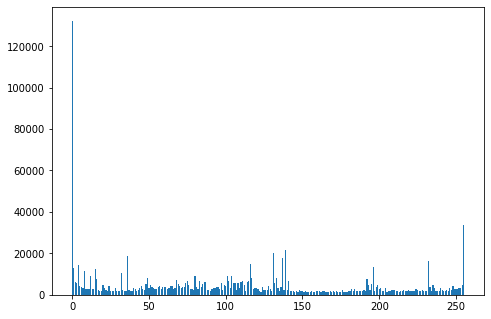

In [ ]:
import matplotlib.pyplot as plt

fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
ax.bar(x = range(256), height = byte_dict.values())
plt.show() #把每一個byte有多少個畫出來

平均而言前面的ASSIC code會比後面的還要多是因為英文字母，用得比較多

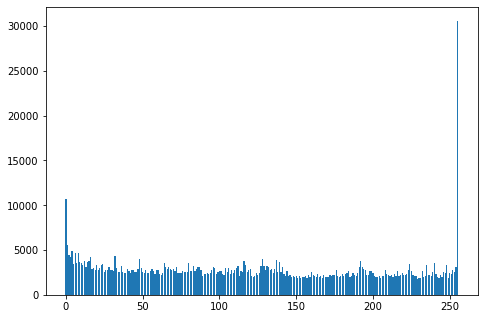

In [ ]:
byte_packed_dict = countByte("/content/putty32_packed.exe")
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
ax.bar(x = range(256), height = byte_packed_dict.values())
plt.show()

加密過的是因為解壓縮是輸出亂碼，要讓人家看不出什麼，所以很平均，有壓縮過的entropy比較亂，每一個byte出現的事件機率，所以很難預測，
所以不見得要看signature，而可以看每一個byte

Question: why? Can you do bi-gram or tri-gram? Need to considering sliding window or not? How many grams needed? Can you find a way to do feature selection on these grams so that we do not need to keep so many features?

### ASM

https://www.capstone-engine.org/lang_python.html

In [ ]:
!pip install capstone

     |████████████████████████████████| 1.9MB 2.6MB/s 


In [ ]:
import capstone
import pefile

pef = pefile.PE("/content/putty32.exe")
entryPoint = pef.OPTIONAL_HEADER.AddressOfEntryPoint
data = pef.get_memory_mapped_image()[entryPoint:]
cs = capstone.Cs(capstone.CS_ARCH_X86, capstone.CS_MODE_32)
for i in cs.disasm(data, 0x1000):
    print("0x%x:\t%s\t%s" %(i.address, i.mnemonic, i.op_str))

Streaming output truncated to the last 5000 lines.
0x1db17:	cmp	dword ptr [esp + 8], 0
0x1db1c:	jne	0x1dadc
0x1db1e:	fstp	st(0)
0x1db20:	fld	xword ptr [0x49d30a]
0x1db26:	mov	eax, 2
0x1db2b:	cmp	dword ptr [0x4bae24], 0
0x1db32:	jne	0x1e7c8
0x1db38:	lea	ecx, [0x49d1a0]
0x1db3e:	mov	edx, 0x1b
0x1db43:	call	0x1e8d1
0x1db48:	pop	edx
0x1db49:	ret	
0x1db4a:	cmp	dword ptr [0x4ba698], 0
0x1db51:	je	0x1db8a
0x1db53:	push	ebp
0x1db54:	mov	ebp, esp
0x1db56:	sub	esp, 8
0x1db59:	and	esp, 0xfffffff8
0x1db5c:	fstp	qword ptr [esp]
0x1db5f:	cvttsd2si	eax, qword ptr [esp]
0x1db64:	leave	
0x1db65:	ret	
0x1db66:	cmp	dword ptr [0x4ba698], 0
0x1db6d:	je	0x1db8a
0x1db6f:	sub	esp, 4
0x1db72:	fnstcw	word ptr [esp]
0x1db75:	pop	eax
0x1db76:	and	ax, 0x7f
0x1db7a:	cmp	ax, 0x7f
0x1db7e:	je	0x1db53
0x1db80:	lea	esp, [esp]
0x1db87:	lea	ecx, [ecx]
0x1db8a:	push	ebp
0x1db8b:	mov	ebp, esp
0x1db8d:	sub	esp, 0x20
0x1db90:	and	esp, 0xfffffff0
0x1db93:	fld	st(0)
0x1db95:	fst	dword ptr [esp + 0x18]
0x1db99:	fistp	qword ptr 

Note: we do not cover control-flow graph (CFG)!

## Fuzzy Hash

Get an older version.

In [ ]:
!wget https://the.earth.li/~sgtatham/putty/0.72/w32/putty.exe -O putty32_old.exe

--2020-04-03 09:29:45--  https://the.earth.li/~sgtatham/putty/0.72/w32/putty.exe
Resolving the.earth.li (the.earth.li)... 93.93.131.124, 2a00:1098:86:4d:c0ff:ee:15:900d
Connecting to the.earth.li (the.earth.li)|93.93.131.124|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1098112 (1.0M) [application/x-msdos-program]
Saving to: ‘putty32_old.exe’

putty32_old.exe     100%[===================>]   1.05M  1.97MB/s    in 0.5s    

2020-04-03 09:29:46 (1.97 MB/s) - ‘putty32_old.exe’ saved [1098112/1098112]



In [ ]:
!apt-get install ssdeep

Reading package lists... Done
Building dependency tree       
Reading state information... Done
ssdeep is already the newest version (2.14-1).
0 upgraded, 0 newly installed, 0 to remove and 25 not upgraded.


In [ ]:
!ssdeep /content/putty32.exe

ssdeep,1.1--blocksize:hash:hash,filename
24576:HnYO/xJrstd2u3Slcfo259gy6Ym4ZrpdSdwwDtrm83zh:dbst4u3vA2PgTqpdSdvDtrm+zh,"/content/putty32.exe"


In [ ]:
!ssdeep /content/putty32_old.exe

ssdeep,1.1--blocksize:hash:hash,filename
24576:wpPg/wTlg6Xklt9e/Y/iIpNh6liEmE2CebHNpVffB:XwRg6X+twii8N0oCeLNbfB,"/content/putty32_old.exe"


In [ ]:
import hashlib
print(hashlib.md5(open("/content/putty32.exe", 'rb').read()).hexdigest())#md5不一樣所以內容是不一樣的
print(hashlib.md5(open("/content/putty32_old.exe", 'rb').read()).hexdigest())

9052d06c6ac53471f8496263f8fef2eb
d9e402762e546c0046ad4748778472e1


In [ ]:
# https://www.fireeye.com/blog/threat-research/2014/01/tracking-malware-import-hashing.html

print(pefile.PE("/content/putty32.exe").get_imphash())
print(pefile.PE("/content/putty32_old.exe").get_imphash()) #import 的dll 是一樣的，所以舊版和新版的hash值是一樣的

d803cf4cabab38ad6ac8123e3c7a53dd
d803cf4cabab38ad6ac8123e3c7a53dd


Question: take a look at pefile's source code? What is imphash?

In [ ]:
!ssdeep -pb *.exe #想要看舊版和新版有多像 100代表有一百個很像

putty32_old.exe matches putty.exe (100)

putty.exe matches putty32_old.exe (100)



Note that python has "ssdeep", but it cannot install in colab directly. https://pypi.org/project/ssdeep/